## Imports and Loading Embeddings File

In [1]:
import sys
print(sys.executable)

e:\Program Files (x86)\Anaconda3\envs\dissertation\pythonw.exe


In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer 
import numpy as np
sys.path.append('E:\GitHubProjects\dissertation\Scripts')
import helperfn as hf
import graphs as gh
%load_ext autoreload
%autoreload 2

In [3]:
from gensim.models import KeyedVectors
embedding_model = KeyedVectors.load_word2vec_format(r'E:\GitHubProjects\dissertation\word2vec\GoogleNews-vectors-negative300.bin', binary=True)
# If we don't plan to train the model any further, calling init_sims will make the model much more memory-efficient.
embedding_model.init_sims(replace=True)

## Loading and Pre-processing the dataset

In [3]:
stop = hf.stop_words()
uni_names = hf.uni_names()

#Get Data
data = hf.merge_datasets(r'E:\GitHubProjects\dissertation\scraper\approved_datasets')
# data = hf.balance_dataset(data)

#Tokenizing the text using NLTK
# TODO ******. doesnt segment full stop 
# https://stackoverflow.com/questions/42056872/how-to-remove-in-strings-with-regexptokenizer
tokenizer = RegexpTokenizer(r'([\w\']+|\[+|]+|\!+|"+|\$+|%+|&+|\'+|\(+|\)+|\*+|\++|,+|\.+|:+|;+|=+|#+|@+|\?+|\[+|\^+|_+|`+|{+|\|+|\}+|~+|-+|]+)') 

data['tokenized_text'] = data['review'].apply(lambda x: tokenizer.tokenize(x)) 

#lower case
data['tokenized_text'] = data['tokenized_text'].apply(lambda x: hf.lower_token(x))

#remove stop words
data['tokenized_text'] = data['tokenized_text'].apply(lambda x: [item for item in x if item not in stop])

#remove university names as they impact accuracy, these words should be neutral sentiment 
data['tokenized_text'] = data['tokenized_text'].apply(lambda x: [item for item in x if item not in uni_names])

#reduce puncuations, remove duplicates next to each other and leave only one e.g. !!! to !
data['tokenized_text'] = data['tokenized_text'].apply(lambda x: hf.remove_punctuations(x))

X, y = data['tokenized_text'], list(data['score'])

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence

#vocab size
NUM_WORDS = 10000
tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

In [5]:
#finding the maximum number of words the longests sentence contains
# longest = 0
# for x in X_train:
#     if len(x.split()) > longest:
#         longest = len(x.split())

#VERSION FOR TOKENIZED ROWS
longest = 0
for x in X:
    if len(x) > longest:
        longest = len(x)

#padding sequences to have the same length
x_train_seq = pad_sequences(sequences, maxlen=longest+5)

In [6]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(x_train_seq, y, test_size=0.2, shuffle=True, stratify=y, random_state=8)
#Converting from list to numPy arrays (fixed errors after tensorflow... imports)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [8]:
#Word Embeddings
#length of vectors in embedding word2vec
embedding_vecor_length = 300
embedding_matrix = np.zeros((NUM_WORDS, embedding_vecor_length))

for word, i in tokenizer.word_index.items():
    if i >= NUM_WORDS:
        continue
    try:
        embedding_vector = embedding_model[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except:
        pass
        # embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25), embedding_vecor_length)

In [7]:
import pickle as pk 
with open("embedding_matrix.pickle", 'rb') as handle:
    embedding_matrix = pk.load(handle)

In [8]:
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPooling1D, AveragePooling1D, Embedding, GlobalMaxPooling1D, Conv1D, GlobalAveragePooling1D, MaxPool1D, concatenate, Activation, Input

## Simple Network 

In [17]:
    model_cnn = Sequential()
    e = Embedding(NUM_WORDS, 300, weights=[embedding_matrix], input_length=longest+5, trainable=False)
    model_cnn.add(e)
    model_cnn.add(Dropout(0.2))
    model_cnn.add(Conv1D(filters=256, kernel_size=1, padding='valid', activation='relu', strides=1))
    model_cnn.add(MaxPooling1D(2))

    model_cnn.add(Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu', strides=1))
    model_cnn.add(MaxPooling1D(3))

    model_cnn.add(Dropout(0.0))

    model_cnn.add(Flatten())
    model_cnn.add(Dense(160, activation='relu'))
    model_cnn.add(Dense(1, activation='sigmoid'))
    adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model_cnn.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    fit_obj = model_cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=21, batch_size=32, verbose=2)
    model_cnn.summary()

Train on 2277 samples, validate on 570 samples
Epoch 1/21
2277/2277 - 7s - loss: 0.6369 - accuracy: 0.7075 - val_loss: 0.5691 - val_accuracy: 0.7368
Epoch 2/21
2277/2277 - 5s - loss: 0.5614 - accuracy: 0.7268 - val_loss: 0.5188 - val_accuracy: 0.7632
Epoch 3/21
2277/2277 - 5s - loss: 0.4868 - accuracy: 0.7668 - val_loss: 0.4051 - val_accuracy: 0.8351
Epoch 4/21
2277/2277 - 6s - loss: 0.3762 - accuracy: 0.8265 - val_loss: 0.3065 - val_accuracy: 0.8719
Epoch 5/21
2277/2277 - 6s - loss: 0.3053 - accuracy: 0.8713 - val_loss: 0.2757 - val_accuracy: 0.8789
Epoch 6/21
2277/2277 - 6s - loss: 0.2903 - accuracy: 0.8783 - val_loss: 0.2567 - val_accuracy: 0.8842
Epoch 7/21
2277/2277 - 5s - loss: 0.2663 - accuracy: 0.8867 - val_loss: 0.2494 - val_accuracy: 0.8965
Epoch 8/21
2277/2277 - 6s - loss: 0.2585 - accuracy: 0.8880 - val_loss: 0.2485 - val_accuracy: 0.8965
Epoch 9/21
2277/2277 - 5s - loss: 0.2448 - accuracy: 0.8928 - val_loss: 0.2359 - val_accuracy: 0.9053
Epoch 10/21
2277/2277 - 5s - loss: 

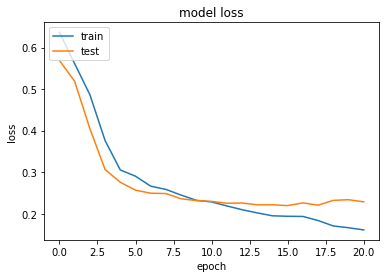

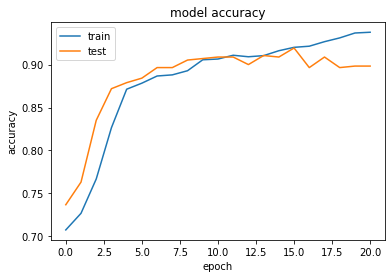

In [20]:
gh.model_loss(fit_obj)
gh.model_accuracy(fit_obj)

## Network with multi n-grams

In [24]:
tweet_input = Input(shape=(longest+5,), dtype='int32')

tweet_encoder = Embedding(NUM_WORDS, 300, weights=[embedding_matrix], input_length=longest+5, trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
fit_obj = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=12, batch_size=32, verbose=2)
# model.summary()

Train on 2277 samples, validate on 570 samples
Epoch 1/12
2277/2277 - 8s - loss: 0.4137 - accuracy: 0.7971 - val_loss: 0.2668 - val_accuracy: 0.9000
Epoch 2/12
2277/2277 - 7s - loss: 0.1932 - accuracy: 0.9284 - val_loss: 0.2394 - val_accuracy: 0.9105
Epoch 3/12
2277/2277 - 7s - loss: 0.1140 - accuracy: 0.9635 - val_loss: 0.2383 - val_accuracy: 0.9193
Epoch 4/12
2277/2277 - 7s - loss: 0.0490 - accuracy: 0.9873 - val_loss: 0.2972 - val_accuracy: 0.9140
Epoch 5/12
2277/2277 - 6s - loss: 0.0212 - accuracy: 0.9969 - val_loss: 0.2946 - val_accuracy: 0.9228
Epoch 6/12
2277/2277 - 6s - loss: 0.0081 - accuracy: 0.9996 - val_loss: 0.3171 - val_accuracy: 0.9228
Epoch 7/12
2277/2277 - 6s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.3291 - val_accuracy: 0.9211
Epoch 8/12
2277/2277 - 6s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.3492 - val_accuracy: 0.9263
Epoch 9/12
2277/2277 - 6s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.3665 - val_accuracy: 0.9281
Epoch 10/12
2277/2277 - 6s - loss: 

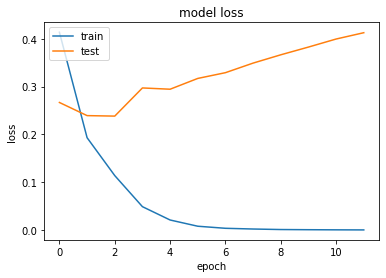

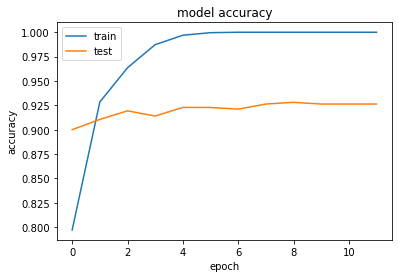

In [25]:
gh.model_loss(fit_obj)
gh.model_accuracy(fit_obj)

## Testing above but with SVM

In [33]:
#multichannel with SVM
tweet_input = Input(shape=(longest+5,), dtype='int32')

tweet_encoder = Embedding(NUM_WORDS, 300, weights=[embedding_matrix], input_length=longest+5, trainable=False)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation='relu')(merged)

# merged = Dense(64, activation='relu')(merged)
merged = Dense(1, kernel_regularizer=regularizers.l2(0.01))(merged)
output = Activation('sigmoid')(merged)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='categorical_hinge',
              optimizer='adadelta',
              metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=32, verbose=2)

model.predict(X_test)

Train on 2277 samples, validate on 570 samples
Epoch 1/3
2277/2277 - 3s - loss: 0.8494 - accuracy: 0.5964 - val_loss: 0.8476 - val_accuracy: 0.6351
Epoch 2/3
2277/2277 - 1s - loss: 0.8482 - accuracy: 0.6298 - val_loss: 0.8464 - val_accuracy: 0.6421
Epoch 3/3
2277/2277 - 1s - loss: 0.8471 - accuracy: 0.6465 - val_loss: 0.8453 - val_accuracy: 0.6579


array([[0.50440884],
       [0.5036342 ],
       [0.49535027],
       [0.49841845],
       [0.5227016 ],
       [0.51093024],
       [0.50940007],
       [0.51868355],
       [0.50979996],
       [0.50804764],
       [0.5273267 ],
       [0.5119745 ],
       [0.5031807 ],
       [0.5008347 ],
       [0.5111786 ],
       [0.5213676 ],
       [0.50176   ],
       [0.50835264],
       [0.51468843],
       [0.50470704],
       [0.5179891 ],
       [0.52046055],
       [0.5141947 ],
       [0.513973  ],
       [0.5138334 ],
       [0.511934  ],
       [0.5081862 ],
       [0.50170344],
       [0.5032527 ],
       [0.5008493 ],
       [0.51095915],
       [0.5078682 ],
       [0.51880825],
       [0.50150377],
       [0.5057223 ],
       [0.51231945],
       [0.50965863],
       [0.50386363],
       [0.51333493],
       [0.49411836],
       [0.50910926],
       [0.5280491 ],
       [0.5121256 ],
       [0.50816405],
       [0.5052746 ],
       [0.50615275],
       [0.50673455],
       [0.496

In [24]:
%%capture

from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch, BayesianOptimization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#TODO Test with and without padding
#TODO Test max and average pooling
#TODO Test strides, Test Dropout

def build_model(hp=None):
    model_cnn = Sequential()
    e = Embedding(NUM_WORDS, 300, weights=[embedding_matrix], input_length=longest+5, trainable=False)
    model_cnn.add(e)

    model_cnn.add(Dropout(hp.Float(f'dropout_start', min_value=0.0, max_value=0.3, step=0.1)))

    # for i in range(hp.Int('n_layers', 1, 3)):
    model_cnn.add(Conv1D(filters=hp.Int(f'conv_units_1', min_value=96, max_value=256, step=32), kernel_size=hp.Int(f'kernel_size_units_1', min_value=1, max_value=3, step=1), padding='valid', activation='relu', strides=1))
    model_cnn.add(AveragePooling1D(hp.Int(f'avgPooling_1', min_value=1, max_value=4, step=1), padding='same'))

    # model_cnn.add(Conv1D(filters=hp.Int(f'conv_units_2', min_value=96, max_value=256, step=32), kernel_size=hp.Int(f'kernel_size_units_2', min_value=1, max_value=3, step=1), padding='valid', activation='relu', strides=1))
    # model_cnn.add(AveragePooling1D(hp.Int(f'avgPooling_2', min_value=1, max_value=4, step=1), padding='same'))

    # model_cnn.add(Conv1D(filters=hp.Int(f'conv_units_3', min_value=96, max_value=256, step=32), kernel_size=hp.Int(f'kernel_size_units_3', min_value=1, max_value=3, step=1), padding='valid', activation='relu', strides=1))
    # model_cnn.add(AveragePooling1D(hp.Int(f'avgPooling_3', min_value=1, max_value=4, step=1), padding='same'))    

    
    model_cnn.add(Dropout(hp.Float(f'dropout_end', min_value=0.0, max_value=0.3, step=0.1)))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(hp.Int(f'last_dense', min_value=32, max_value=256, step=32), activation='relu'))
    # model_cnn.add(Dense(256, activation='relu'))
    model_cnn.add(Dense(1, activation='sigmoid'))
    model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_cnn


tuner = BayesianOptimization(
    build_model,
    objective= 'val_accuracy',
    max_trials = 50,
    executions_per_trial = 2,
    directory = 'bayesian_search',
    project_name='oneConvAveragePooling',
    overwrite = True
)

callback = [EarlyStopping(monitor='val_loss', patience=1)]

tuner.search(
    x=X_train,
    y=y_train,
    epochs=8,
    batch_size=64,
    verbose=0,
    callbacks=callback,
    validation_data=(X_test, y_test)
)

import pickle as pk
# saving the tokenizer
with open('tuner_ml2.pickle', 'wb') as handle:
    pk.dump(tuner, handle, protocol=pk.HIGHEST_PROTOCOL)

INFO:tensorflow:Oracle triggered exit


In [25]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.evaluate(X_test, y_test)

570/570 [==============================] - 0s 475us/sample - loss: 0.2261 - accuracy: 0.9123


[0.22607805666170622, 0.9122807]

In [21]:
import pickle as pk
with open("twoLayers.pickle", 'rb') as handle:
    tuner = pk.load(handle)

tuner.get_best_hyperparameters()[0].values

AttributeError: Can't get attribute 'build_model' on <module '__main__'>

In [12]:
fit_obj = best_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=2)

Train on 2277 samples, validate on 570 samples
Epoch 1/20
2277/2277 - 2s - loss: 0.1042 - accuracy: 0.9679 - val_loss: 0.2519 - val_accuracy: 0.9158
Epoch 2/20
2277/2277 - 1s - loss: 0.0714 - accuracy: 0.9754 - val_loss: 0.2771 - val_accuracy: 0.9088
Epoch 3/20
2277/2277 - 1s - loss: 0.0379 - accuracy: 0.9912 - val_loss: 0.3388 - val_accuracy: 0.9070
Epoch 4/20
2277/2277 - 1s - loss: 0.0233 - accuracy: 0.9969 - val_loss: 0.3551 - val_accuracy: 0.9193
Epoch 5/20
2277/2277 - 1s - loss: 0.0189 - accuracy: 0.9960 - val_loss: 0.3671 - val_accuracy: 0.9123
Epoch 6/20
2277/2277 - 1s - loss: 0.0098 - accuracy: 0.9978 - val_loss: 0.4706 - val_accuracy: 0.9000
Epoch 7/20
2277/2277 - 1s - loss: 0.0165 - accuracy: 0.9956 - val_loss: 0.4569 - val_accuracy: 0.9035
Epoch 8/20
2277/2277 - 1s - loss: 0.0205 - accuracy: 0.9947 - val_loss: 0.4352 - val_accuracy: 0.8965
Epoch 9/20
2277/2277 - 1s - loss: 0.0225 - accuracy: 0.9921 - val_loss: 0.4659 - val_accuracy: 0.8930
Epoch 10/20
2277/2277 - 1s - loss: 

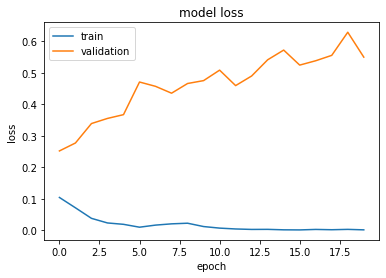

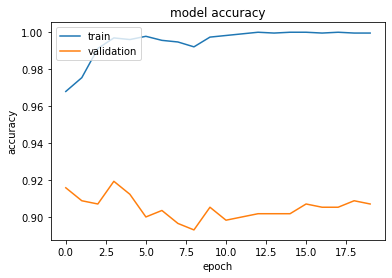

In [14]:
gh.model_loss(fit_obj)
gh.model_accuracy(fit_obj)

## Confusion Matrix and Metrics

In [12]:
from sklearn.metrics import confusion_matrix

y_pred = (model_cnn.predict(X_test).ravel()>0.5)+0 # predict and get class (0 if pred < 0.5 else 1)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
confusion_matrix(y_test, y_pred)

array([[151,  38],
       [ 21, 360]], dtype=int64)

In [13]:
print("Precision: ", tp / (tp+fp))
print("Recall: ", tp / (tp+fn))

Precision:  0.9401041666666666
Recall:  0.94750656167979


## Exporting tokenizer and trained model to store as files

In [14]:
import pickle as pk
# saving the tokenizer
with open('tokenizer_m1.pickle', 'wb') as handle:
    pk.dump(tokenizer, handle, protocol=pk.HIGHEST_PROTOCOL)
    
model.save("model_exported.h5")